# *Prediction with or with out Real Price*

You can change the plot, if you want to see the real price only switch 'off' for 'on' in *RealPrice*

With out real price


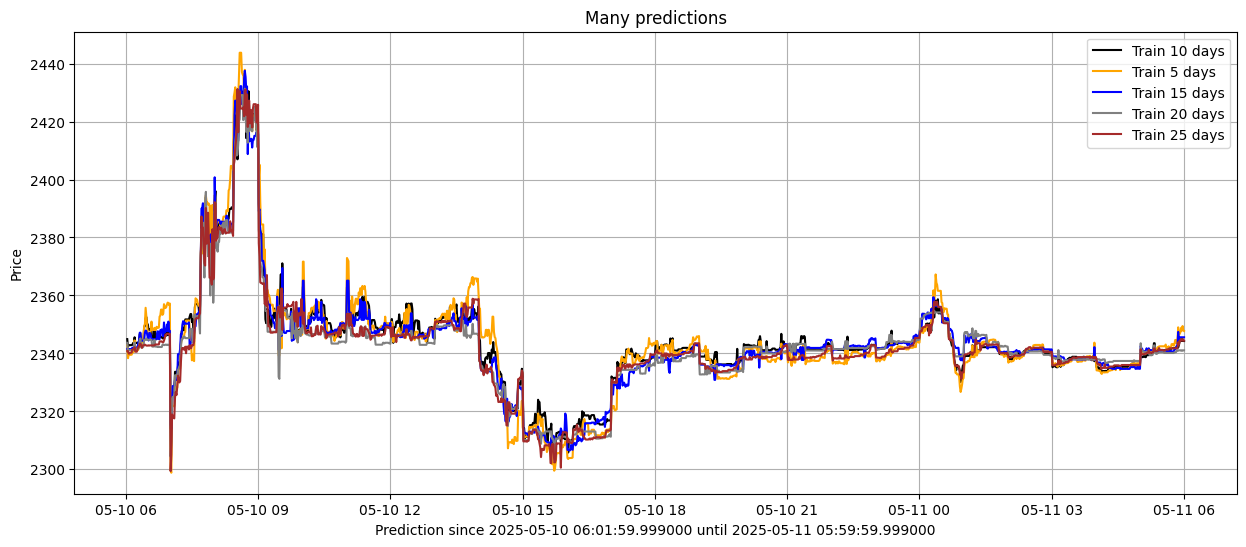

In [77]:
%matplotlib inline
from indicators import ModelIndicators
 
end_time = '2025-05-10 06:00:00'
 
crypto='ETHUSDT'
time='min'

FirstTime= 5
SecondTime=10
ThirdTime= 15
FourthTime=20
FifthTime= 25

RealPrice = 'off'
ShowImage = 'on'

test = ModelIndicators().XGBoostFinalFivePreds(end_time, FirstTime, SecondTime, ThirdTime, FourthTime, FifthTime, crypto, time)
plot_1 = ModelIndicators().CreateImagesFivePreds(data=test, RealPrice=RealPrice, ShowImage=ShowImage)

# Profit or mismatch

Following the last plot, try to do one prediction, it means you put one hour in the space *time* and next the alghoritm show you your profit or mismatch in percent and dollars

In [92]:

hour = '08:32:59.999'
time = '2025-05-10 08:30:59.999'
price = test[test['ds'] == test['ds'].min()]['Real Price'].values[0]


profit = round(test[test['ds'] == time]['Real Price'].values[0] - price, 3)
percent = round((profit*100)/price, 3)

print('='*50,'>>', f'{profit} Dolars', '<<', '='*50)
print('='*50, '>>', f'{percent}% Profit' ,'<<', '='*50)


================================================== >> 56.88 Dolars << ==================================================
================================================== >> 2.412% Profit << ==================================================


# *Many plots*

You can predict differents days at the same time, it means, you can calculate from an especific date until right now. Remember you can do that wit or with out *RealPrice*. You only need change 'off' for 'on'

With out real price
Img
With out real price
Img
With out real price
Img
With out real price
Img
With out real price
Img
With out real price
Img
With out real price
Img
With out real price
Img
With out real price
Img
With out real price
Img
With out real price
Img


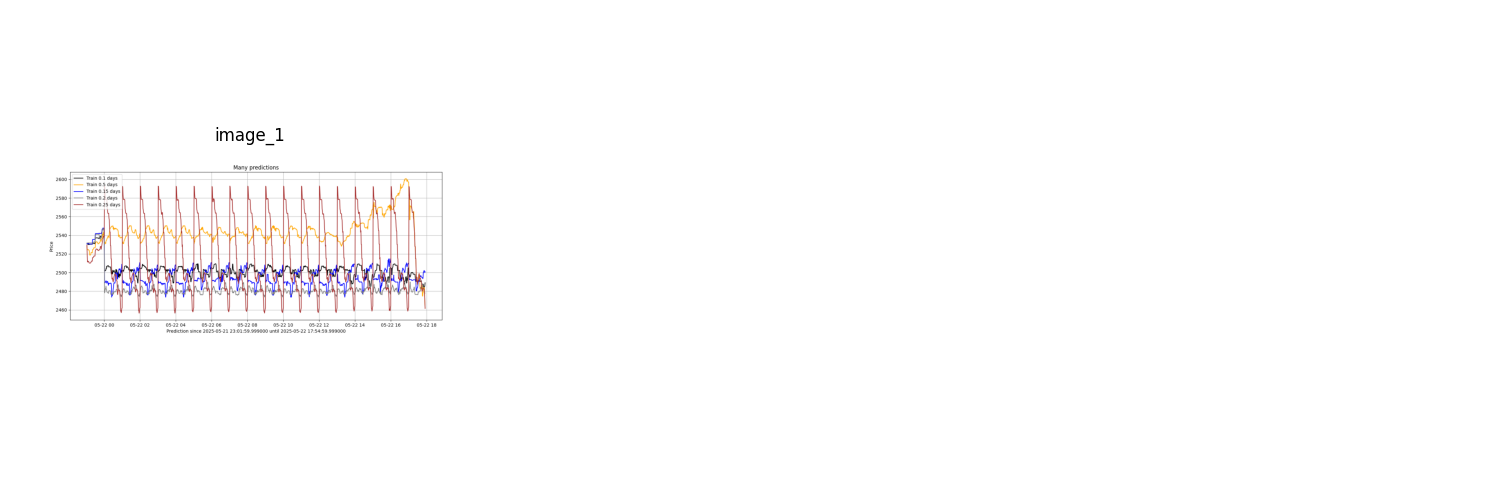

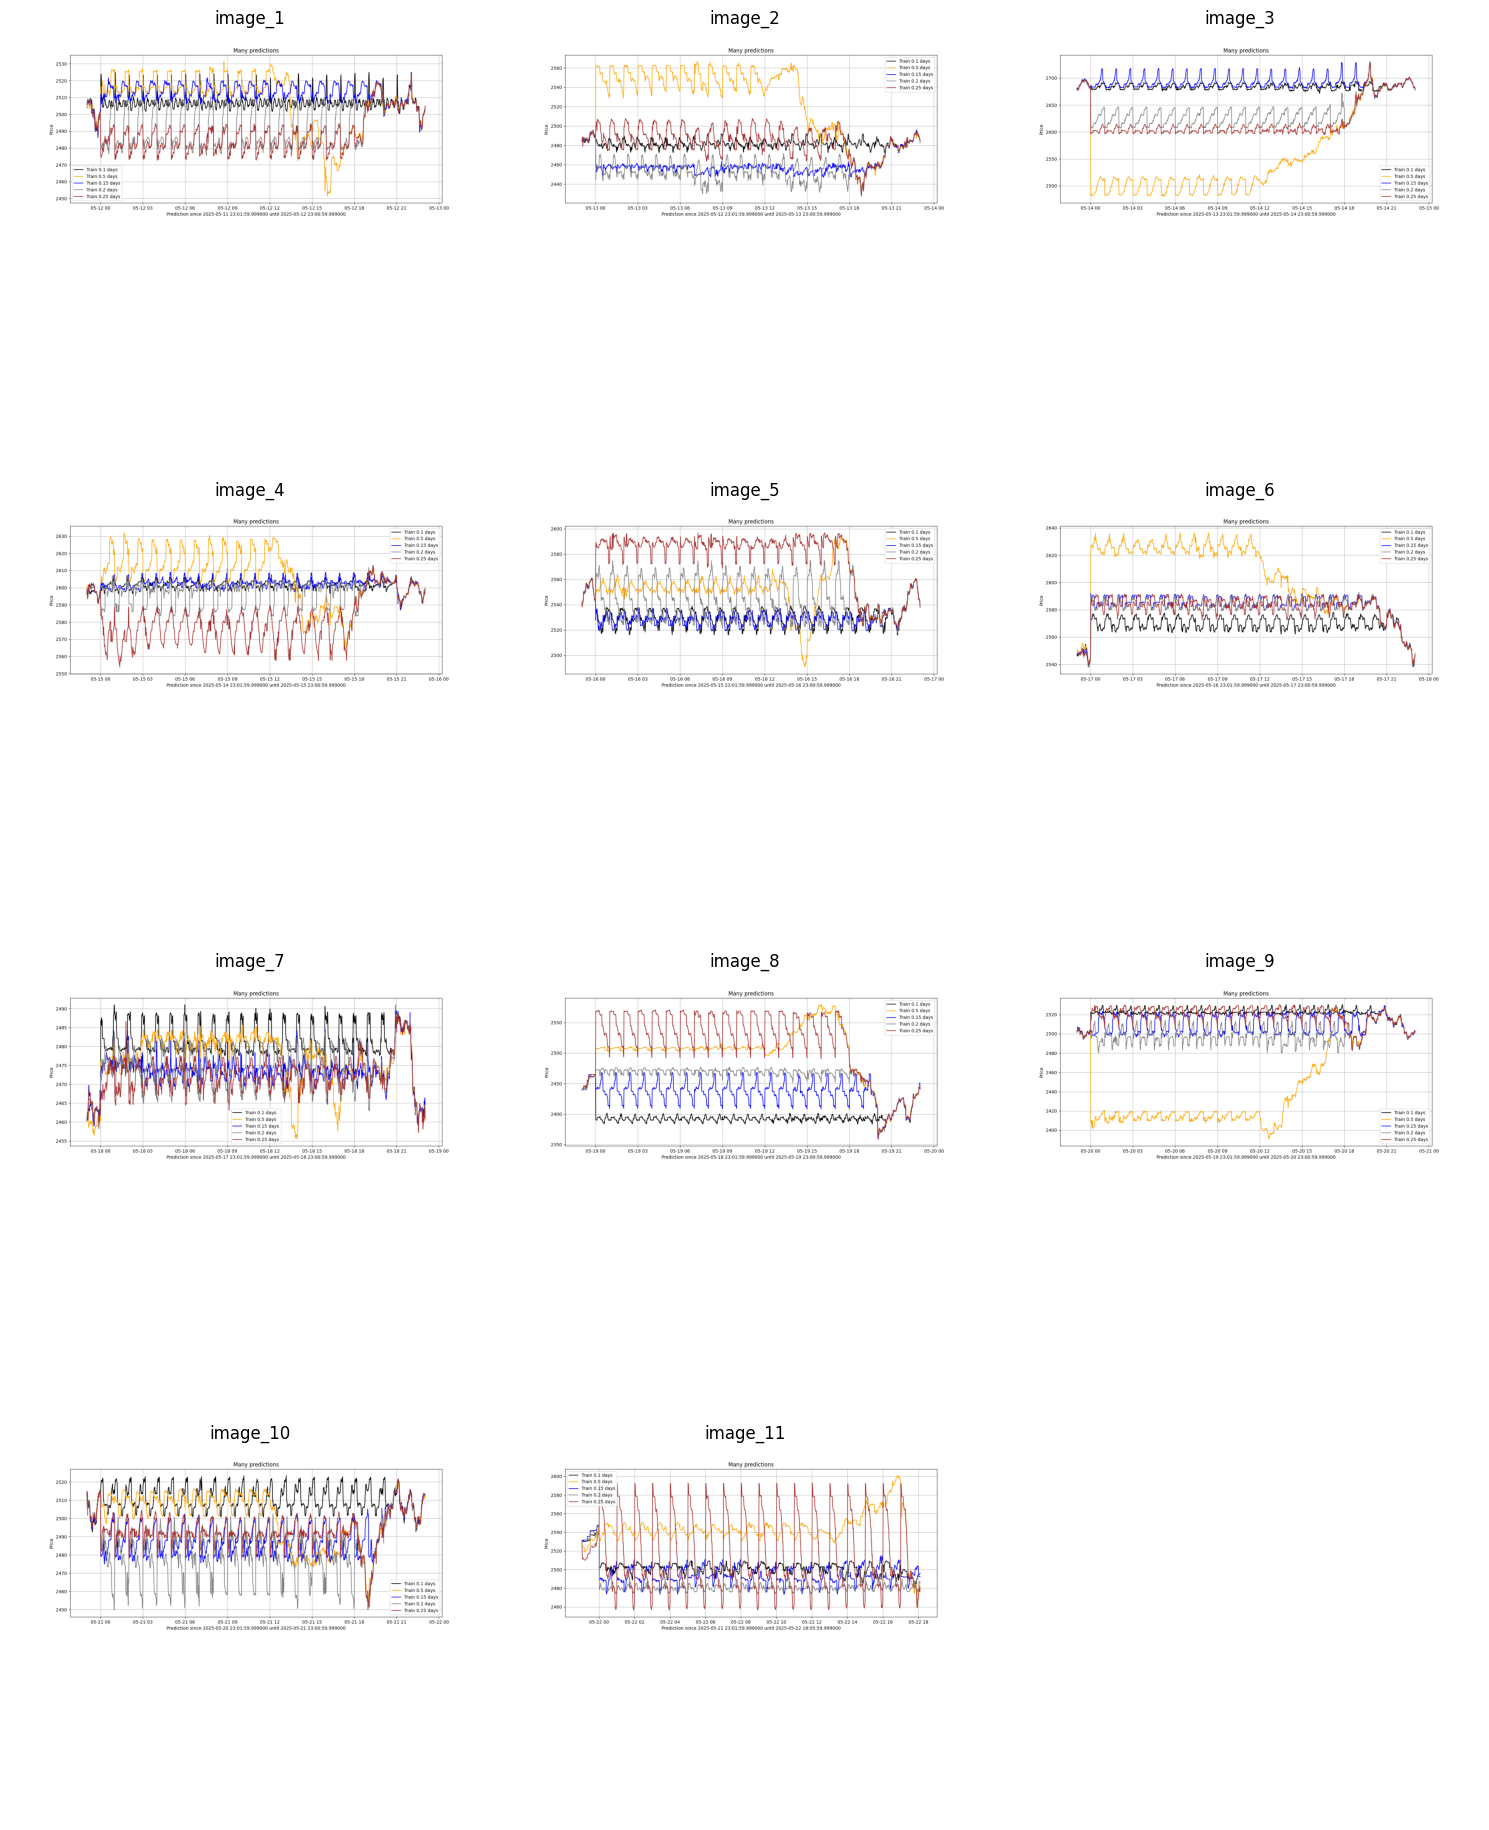

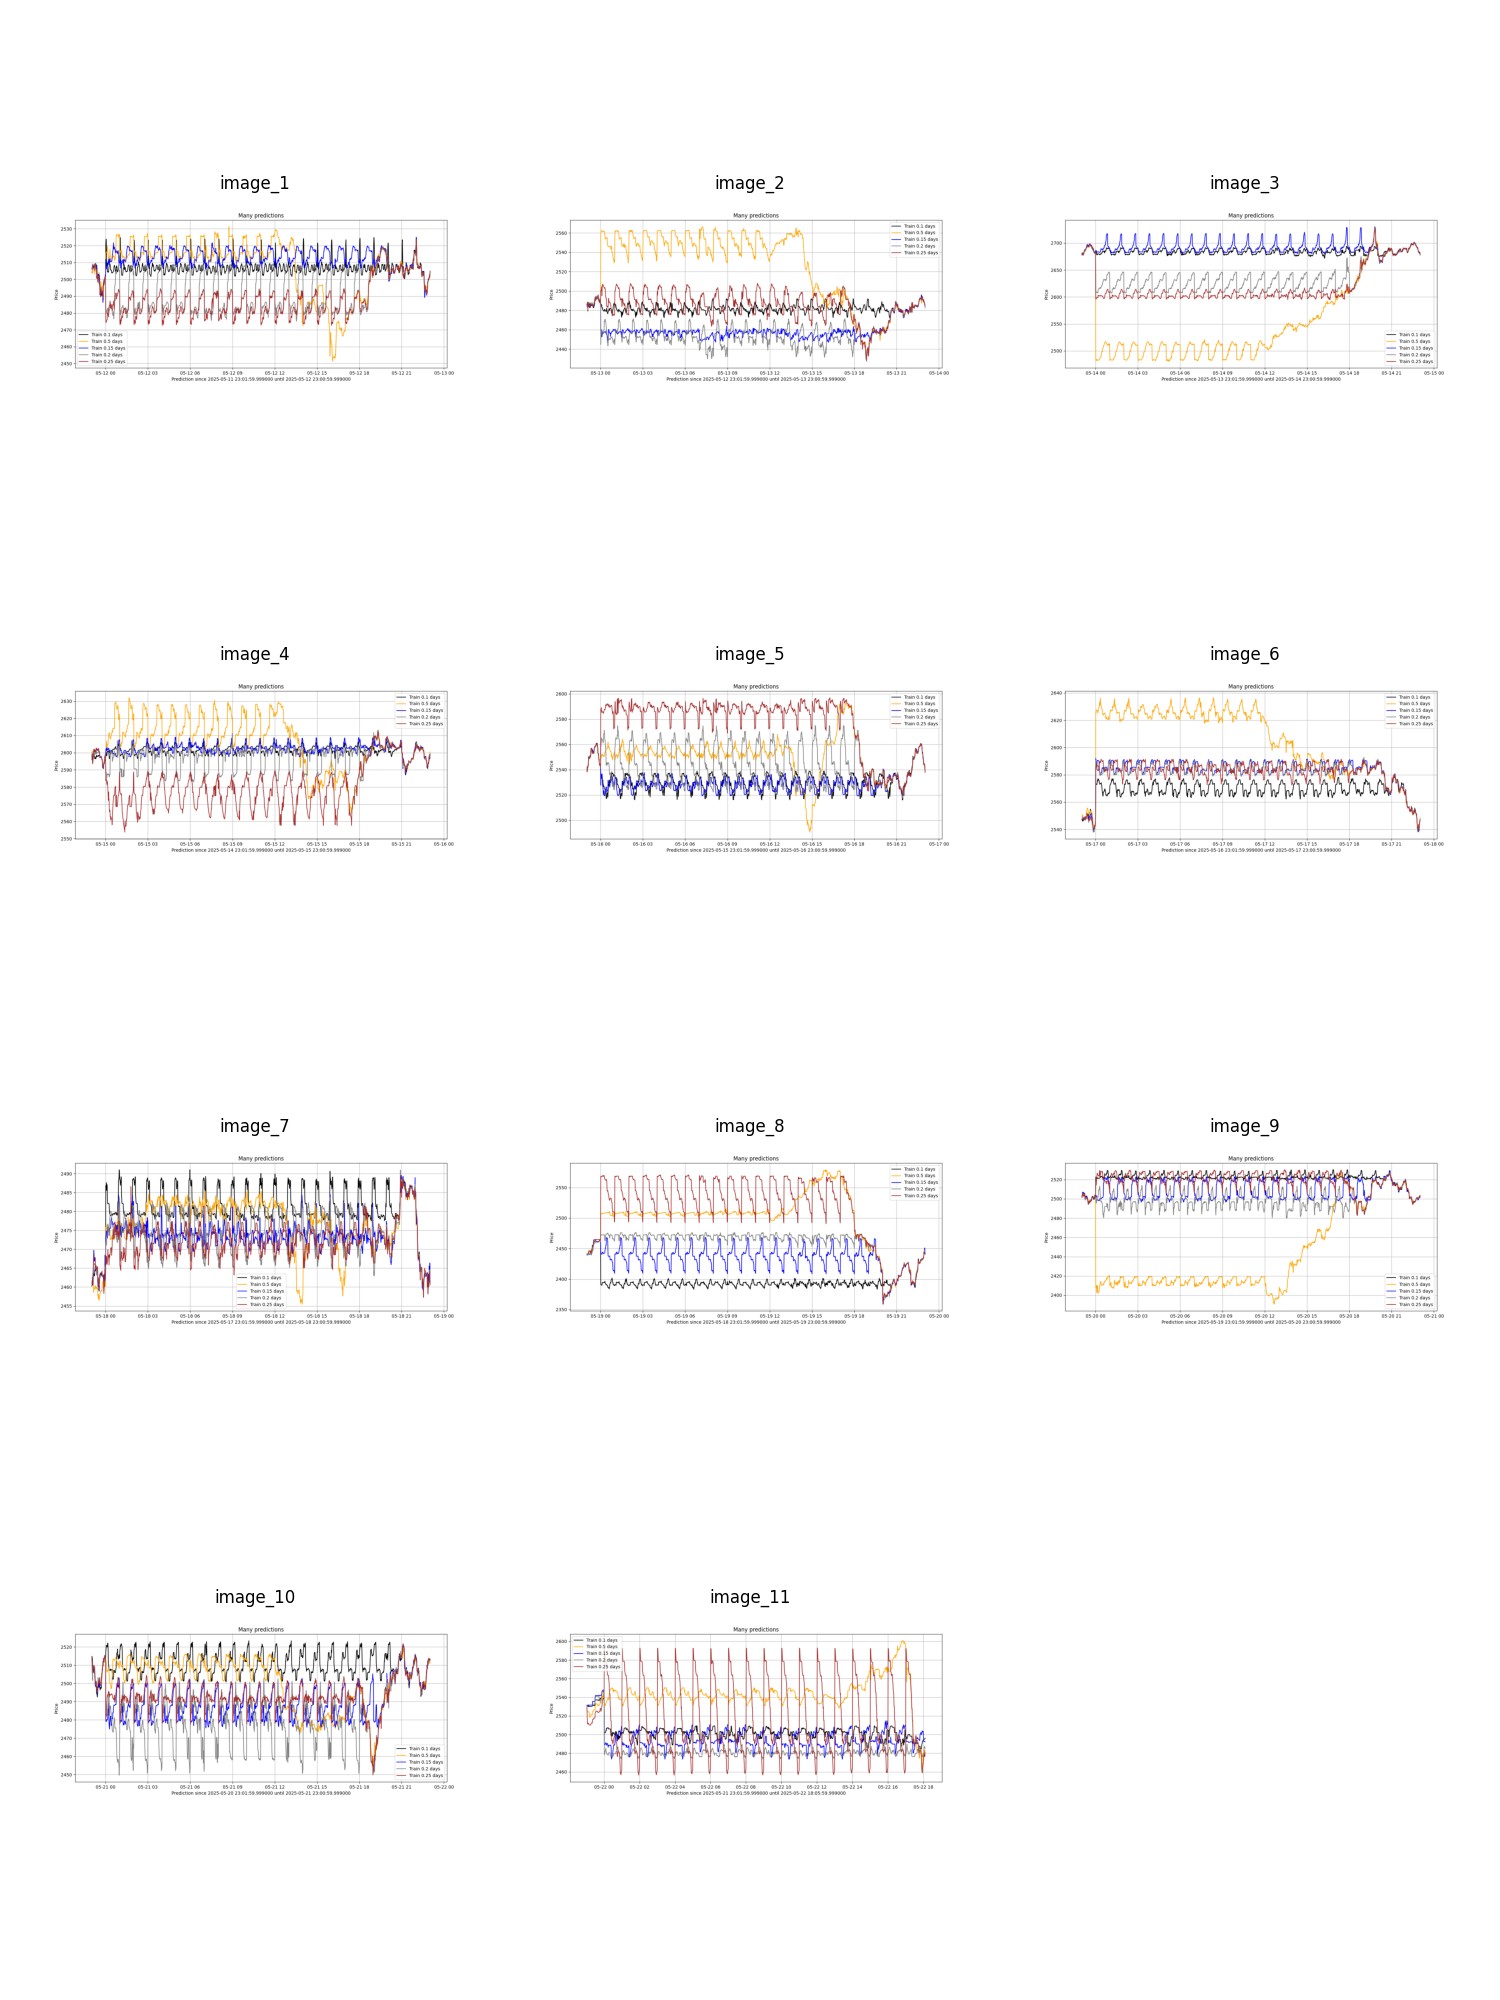

Its Working :)


In [ ]:
%matplotlib inline

from indicators import ModelIndicators
 
SinceDate = '2025-05-20 23:00:00'
 
crypto='ETHUSDT'
time='min'

FirstTime= 0.5
SecondTime=0.10
ThirdTime= 0.15
FourthTime=0.20
FifthTime= 0.25

RealPrice = 'off'

test = ModelIndicators().ManyPlots(SinceDate=SinceDate, FirstTime=FirstTime, SecondTime=SecondTime, 
                                   ThirdTime=ThirdTime, FourthTime=FourthTime, FifthTime=FifthTime, 
                                   crypto=crypto, time=time, RealPrice=RealPrice)

# Futures Predictions

For any reason it's not working for more than six hours

With out real price


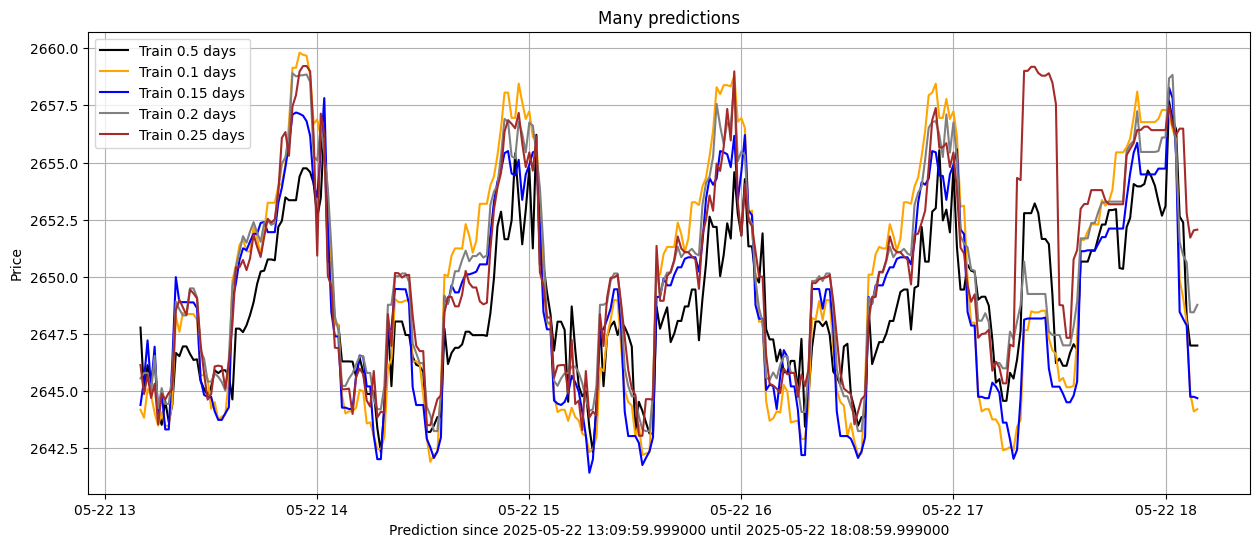

In [3]:
from indicators import ModelIndicators
 
crypto='ETHUSDT'
time='min'

FirstTime= 0.5
SecondTime=0.10
ThirdTime= 0.15
FourthTime=0.20
FifthTime= 0.25


RealPrice = 'off'
ShowImage = 'on'

test = ModelIndicators().predictions(FirstTime, SecondTime, ThirdTime, FourthTime, FifthTime, crypto, time)
plot_1 = ModelIndicators().CreateImagesFivePreds(data=test, RealPrice=RealPrice, ShowImage=ShowImage)